In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("font", size=14)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
csv_adbe = "C:/Business analysis/Project/IS403.O22.HTCLL_Nhom07/Dataset/ADBE_Stock.csv"
df_adbe = pd.read_csv(csv_adbe, thousands=',')

In [3]:
df_adbe.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,3/1/2019,ADBE,264.010010,264.010010,266.239990,261.500000,265.750000,2594000
1,3/4/2019,ADBE,258.160004,258.160004,267.000000,254.080002,266.700012,2994900
2,3/5/2019,ADBE,257.380005,257.380005,259.869995,256.369995,259.000000,2101800
3,3/6/2019,ADBE,256.399994,256.399994,259.489990,253.839996,257.399994,1950500
4,3/7/2019,ADBE,255.460007,255.460007,257.489990,253.289993,255.770004,3185200


In [4]:
df_adbe.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1.324000e+03
mean,437.561171,437.561171,442.956797,431.746496,437.548852,2.987458e+06
std,112.802864,112.802864,113.786692,111.798628,112.881015,1.733830e+06
min,254.740005,254.740005,255.020004,249.100006,251.490005,5.892000e+05
25%,339.532501,339.532501,344.690010,333.492500,338.960007,2.039850e+06
50%,443.785004,443.785004,449.224991,436.915009,444.769989,2.573100e+06
75%,514.142502,514.142502,520.422485,508.869987,514.000000,3.413750e+06
max,688.369995,688.369995,699.539978,678.909973,696.280029,2.784020e+07


In [5]:
df_adbe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1324 non-null   object 
 1   Symbol     1324 non-null   object 
 2   Adj Close  1324 non-null   float64
 3   Close      1324 non-null   float64
 4   High       1324 non-null   float64
 5   Low        1324 non-null   float64
 6   Open       1324 non-null   float64
 7   Volume     1324 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 82.9+ KB


In [6]:
# Convert object to datetime64
df_adbe['Date'] = df_adbe['Date'].apply(pd.to_datetime)
# Sort data by date time value
df_adbe = df_adbe.sort_values(by="Date").reset_index(drop=True)
df_adbe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1324 non-null   datetime64[ns]
 1   Symbol     1324 non-null   object        
 2   Adj Close  1324 non-null   float64       
 3   Close      1324 non-null   float64       
 4   High       1324 non-null   float64       
 5   Low        1324 non-null   float64       
 6   Open       1324 non-null   float64       
 7   Volume     1324 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 82.9+ KB


In [7]:
df_adbe.Close

0       264.010010
1       258.160004
2       257.380005
3       256.399994
4       255.460007
           ...    
1319    478.429993
1320    477.600006
1321    445.869995
1322    444.760010
1323    439.019989
Name: Close, Length: 1324, dtype: float64

In [8]:
rows = []
for _,row in tqdm(df_adbe.iterrows(), total=df_adbe.shape[0]):
    row_data = dict(
        date = row.Date,
        open = row.Open,
        low = row.Close,
        high = row.High, 
        close = row.Close, 
        volume = row.Volume,
    )
    rows.append(row_data)
features_adbe = pd.DataFrame(rows)

  0%|          | 0/1324 [00:00<?, ?it/s]

In [9]:
features_adbe.head()

,date,open,low,high,close,volume
0,2019-03-01,265.750000,264.010010,266.239990,264.010010,2594000
1,2019-03-04,266.700012,258.160004,267.000000,258.160004,2994900
2,2019-03-05,259.000000,257.380005,259.869995,257.380005,2101800
3,2019-03-06,257.399994,256.399994,259.489990,256.399994,1950500
4,2019-03-07,255.770004,255.460007,257.489990,255.460007,3185200


In [10]:
def detect_outlier(df, col):
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(df[(df[col] < lower_bound) | (df[col] > upper_bound)])

In [11]:
detect_outlier(features_adbe, 'close')

Empty DataFrame
Columns: [date, open, low, high, close, volume]
Index: []


In [12]:
features_adbe = features_adbe.set_index("date")
features_adbe.head()

,open,low,high,close,volume
date,,,,,
2019-03-01,265.750000,264.010010,266.239990,264.010010,2594000
2019-03-04,266.700012,258.160004,267.000000,258.160004,2994900
2019-03-05,259.000000,257.380005,259.869995,257.380005,2101800
2019-03-06,257.399994,256.399994,259.489990,256.399994,1950500
2019-03-07,255.770004,255.460007,257.489990,255.460007,3185200


In [13]:
train_size = int(0.7 * len(features_adbe))
test_size = len(features_adbe)-train_size

train_adbe_df = features_adbe[:train_size]
test_adbe_df = features_adbe[train_size:]

Text(0.5, 1.0, 'Time Series Plots of adbe stock')

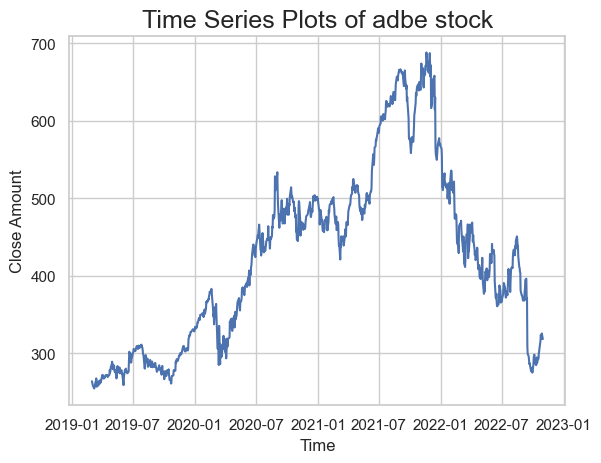

In [14]:
fig, ax = plt.subplots()
ax.plot(train_adbe_df.index, train_adbe_df['close'])
ax.set_ylabel('Close Amount')
ax.set_xlabel('Time')
ax.set_title('Time Series Plots of adbe stock', size=18)

The additive method is useful when the trend and seasonal variation is relatively constant over time as shown below whereas the multiplicative method is useful when the trend and seasonal variation increases or decreases in magnitude over time

Text(0.5, 0, 'Y')

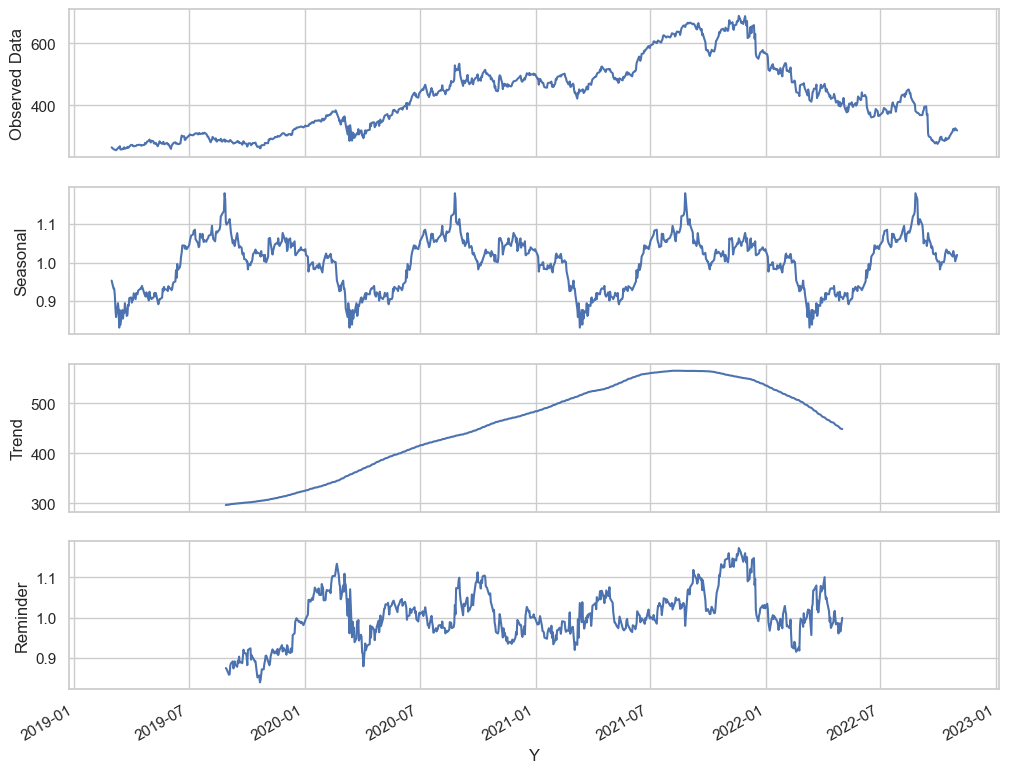

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(train_adbe_df['close'], model='multiplicative', period=252)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10), sharex= True)
res.observed.plot(ax=ax1)
ax1.set_ylabel('Observed Data')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.trend.plot(ax=ax3)
ax3.set_ylabel('Trend')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Reminder')

plt.xlabel("Y")

In [16]:
# Define your parameter grid
param_grid = {
    'error': ['add', 'mul'],
    'trend': ['add','mul', None],
    'damped_trend': [False, True],
    'seasonal': ['add', None, 'mul'],
    'seasonal_periods': [7, 14, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]
}

# Initialize variables to store the best score, parameters, and model
best_aic = float('inf')
best_params = None
best_model = None

# Ensure the data passed to ETSModel is 1-dimensional and has date index with frequency
train_series = pd.Series(train_adbe_df['close'].values, index=pd.date_range(start=train_adbe_df.index[0], periods=len(train_adbe_df), freq='D'))
test_series = pd.Series(test_adbe_df['close'].values, index=pd.date_range(start=test_adbe_df.index[0], periods=len(test_adbe_df), freq='D'))

# Iterate over all combinations of parameters
for error in param_grid['error']:
    for trend in param_grid['trend']:
        damped_trend_values = [False] if trend is None else param_grid['damped_trend']
        for damped_trend in damped_trend_values:
            for seasonal in param_grid['seasonal']:
                for seasonal_periods in param_grid['seasonal_periods']:
                    try:
                        # Check if seasonal_periods is valid with the given seasonal component
                        if seasonal is None and seasonal_periods is not None:
                            continue
                        
                        # Define and fit the model
                        model = ETSModel(train_series, 
                                         error=error,
                                         trend=trend,
                                         damped_trend=damped_trend, 
                                         seasonal=seasonal, 
                                         seasonal_periods=seasonal_periods,
                                         initialization_method='heuristic')
                        model_fit = model.fit()

                        # Make predictions with date index preserved
                        # Get AIC score
                        aic_score = model_fit.aic
                        
                        # Update the best model if the current one has lower AIC
                        if aic_score < best_aic:
                            best_aic = aic_score
                            best_params = {
                                'error': error,
                                'trend': trend,
                                'damped_trend': damped_trend,
                                'seasonal': seasonal,
                                'seasonal_periods': seasonal_periods
                            }
                            best_model = model_fit

                    except Exception as e:
                        print(f"An error occurred for parameters (error={error}, trend={trend}, damped_trend={damped_trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods}): {e}")
                        continue

# Output the best model's AIC
if best_model is not None:
    print('Best model')
    print(f"Best Parameters: {best_params}")
    print(f"Best AIC: {best_aic}")

Best model
Best Parameters: {'error': 'mul', 'trend': None, 'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 180}
Best AIC: 6709.770275709549


In [17]:
# Quá trình testing
# Forecast the values for the test set
test_predictions = best_model.predict(start=len(train_adbe_df), end=len(train_adbe_df) + len(test_adbe_df) - 1 )
test_dates = pd.Series(test_adbe_df.index)  # Adjust freq as per your data
y_pred = test_predictions
test_predictions.index = test_dates
# Output the forecasted values for the test set
print("Test Set Predictions:")
print(test_predictions)

Test Set Predictions:
date
2022-11-01    319.529891
2022-11-02    318.281739
2022-11-03    320.817580
2022-11-04    319.066469
2022-11-07    313.730772
                 ...    
2024-05-28    336.855476
2024-05-29    335.444909
2024-05-30    335.208827
2024-05-31    331.751596
2024-06-03    334.033535
Length: 398, dtype: float64


In [18]:
#Evaluating algorithm accuracy using
y_test = test_adbe_df['close']
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
print('Testing MAE:', test_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print('Testing MAPE:', test_mape)

Testing RMSE: 176.57970853511713
Testing MAE: 146.8032578734701
Testing MAPE: 0.28000774174947324


In [19]:
#Predict the closing prices for the next 30 days
forecast_horizon = 30
forecast_dates = pd.date_range(start=features_adbe.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
forecast_30_days = best_model.predict(start=len(features_adbe), end=len(features_adbe) + forecast_horizon - 1)
forecast_30_days.index = forecast_dates
print(forecast_30_days)

2024-06-04    335.436220
2024-06-05    337.234461
2024-06-06    335.472928
2024-06-07    332.509236
2024-06-08    324.140824
2024-06-09    322.429942
2024-06-10    323.260372
2024-06-11    322.885081
2024-06-12    326.135510
2024-06-13    321.021989
2024-06-14    326.546289
2024-06-15    318.962133
2024-06-16    315.453929
2024-06-17    310.454524
2024-06-18    314.528866
2024-06-19    313.282879
2024-06-20    307.464396
2024-06-21    322.774359
2024-06-22    306.243351
2024-06-23    311.889360
2024-06-24    306.977916
2024-06-25    314.707133
2024-06-26    309.698985
2024-06-27    315.111277
2024-06-28    318.849645
2024-06-29    316.320628
2024-06-30    331.341744
2024-07-01    326.989230
2024-07-02    332.089719
2024-07-03    330.749420
Freq: D, dtype: float64


In [20]:
#Predict the closing prices for the next 60 days
forecast_horizon = 60
forecast_dates = pd.date_range(start=features_adbe.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
forecast_60_days = best_model.predict(start=len(features_adbe), end=len(features_adbe) + forecast_horizon - 1)
forecast_60_days.index = forecast_dates
print(forecast_60_days)

2024-06-04    335.436220
2024-06-05    337.234461
2024-06-06    335.472928
2024-06-07    332.509236
2024-06-08    324.140824
2024-06-09    322.429942
2024-06-10    323.260372
2024-06-11    322.885081
2024-06-12    326.135510
2024-06-13    321.021989
2024-06-14    326.546289
2024-06-15    318.962133
2024-06-16    315.453929
2024-06-17    310.454524
2024-06-18    314.528866
2024-06-19    313.282879
2024-06-20    307.464396
2024-06-21    322.774359
2024-06-22    306.243351
2024-06-23    311.889360
2024-06-24    306.977916
2024-06-25    314.707133
2024-06-26    309.698985
2024-06-27    315.111277
2024-06-28    318.849645
2024-06-29    316.320628
2024-06-30    331.341744
2024-07-01    326.989230
2024-07-02    332.089719
2024-07-03    330.749420
2024-07-04    327.259075
2024-07-05    328.839746
2024-07-06    327.978246
2024-07-07    331.441002
2024-07-08    329.985918
2024-07-09    328.247057
2024-07-10    329.457919
2024-07-11    331.175785
2024-07-12    337.076606
2024-07-13    331.627420


In [21]:
#Predict the closing prices for the next 90 days
forecast_horizon = 90
forecast_dates = pd.date_range(start=features_adbe.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
forecast_90_days = best_model.predict(start=len(features_adbe), end=len(features_adbe) + forecast_horizon - 1)
forecast_90_days.index = forecast_dates
print(forecast_90_days)

2024-06-04    335.436220
2024-06-05    337.234461
2024-06-06    335.472928
2024-06-07    332.509236
2024-06-08    324.140824
                 ...    
2024-08-28    321.747069
2024-08-29    323.630599
2024-08-30    327.734557
2024-08-31    323.793117
2024-09-01    327.098528
Freq: D, Length: 90, dtype: float64


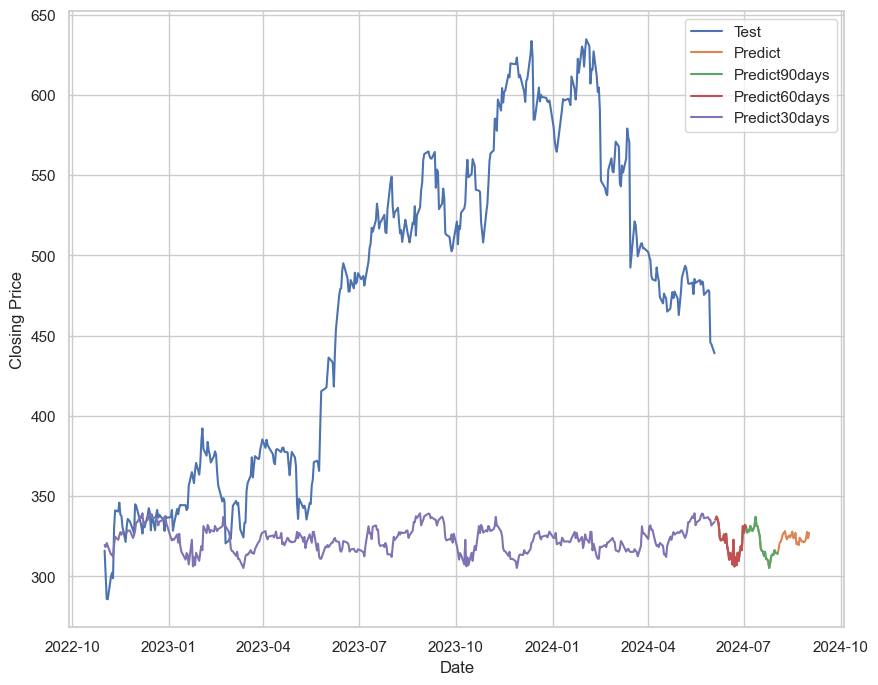

In [22]:
#Vẽ hình
plt.figure(figsize=(10, 8))
plt.plot(test_adbe_df['close'])
plt.plot(forecast_90_days)
plt.plot(forecast_60_days)
plt.plot(forecast_30_days)
plt.plot(test_predictions)
plt.legend(['Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

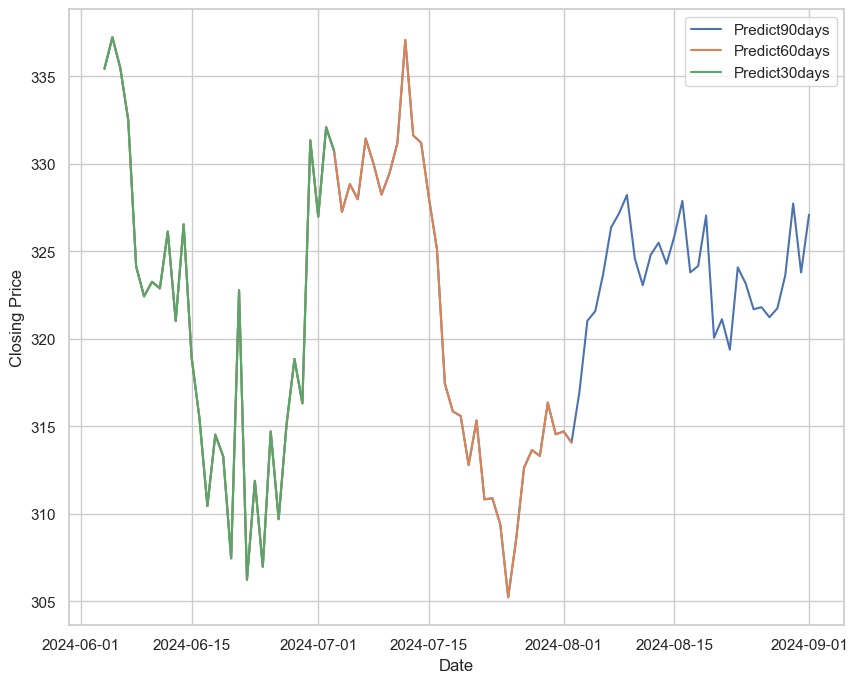

In [23]:
#Vẽ hình
plt.figure(figsize=(10, 8))
plt.plot(forecast_90_days)
plt.plot(forecast_60_days)
plt.plot(forecast_30_days)
plt.legend(['Predict90days', 'Predict60days', 'Predict30days'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()